In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora

import matplotlib.pyplot as plt
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import string 

C:\Users\all\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Read Data

In [119]:
os.chdir(r'E:\Capstone\aflac\final files')
data = pd.read_csv('final.csv')
print(data.shape)
print('\n')
print(data.columns)
print('\n')
print(data.info())
data.head()

(4937, 22)


Index(['User', 'Tweet_id', 'Timestamp', 'Message', 'Hashtags', 'Replies',
       'Retweets', 'Likes', 'Location', 'State', 'City', 'is_duplicated',
       'Sentiment_list', 'Sentiment', 'Score', 'Phrase', 'Emotion_list',
       'Emotion', 'Emotion_score', 'Company', 'Category', 'clean_message'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 22 columns):
User              4937 non-null object
Tweet_id          4937 non-null object
Timestamp         4936 non-null object
Message           4937 non-null object
Hashtags          1766 non-null object
Replies           2492 non-null object
Retweets          2806 non-null object
Likes             3188 non-null object
Location          4937 non-null object
State             4937 non-null object
City              4937 non-null object
is_duplicated     4937 non-null bool
Sentiment_list    4937 non-null object
Sentiment         4937 non-null object
Score          

,User,Tweet_id,Timestamp,Message,Hashtags,Replies,Retweets,Likes,Location,State,...,Sentiment_list,Sentiment,Score,Phrase,Emotion_list,Emotion,Emotion_score,Company,Category,clean_message
0,@TNAOR,1.04E+18,9/24/2018 9:00,Big news We are developing statewide Associati...,NaN,NaN,2,1,"Nashville, TN",TN,...,"['Positive', 0.5011284351348877]",Positive,0.501128,"['Big news', 'statewide Association Health Pla...","['joy', 0.5747424364089966]",joy,0.574742,Colonial Life,Supplemental insurance,big news developing statewide association heal...
1,@rtgins,1.03E+18,8/16/2018 6:10,Employee benefits from Colonial Life Voluntary...,NaN,NaN,NaN,NaN,"Greenville, NC",NC,...,"['Neutral', 0.9640172123908997]",Neutral,0.964017,"['Employee benefits', 'Colonial Life Voluntary...","['anger', 0.48432987928390503]",anger,0.484330,Colonial Life,Supplemental insurance,employee benefit colonial life voluntary benef...
2,@haleakela19,1.02E+18,7/25/2018 20:26,Everyone who can should have supplemental insu...,NaN,1,NaN,5,"Beach, SoCal",Unknown,...,"['Neutral', 0.621531069278717]",Neutral,0.621531,"['supplemental insurance', 'the last 5 years',...","['sadness', 0.7281076908111572]",sadness,0.728108,Colonial Life,Supplemental insurance,everyone supplemental insurance last 5 year ba...
3,@NanaMary__,9.89E+17,4/23/2018 13:34,Rosie let s get this show on the road NanaMary...,#NanaMaryMonday,1,2,7,A free spirit in Lanford.,Unknown,...,"['Neutral', 0.9910300970077515]",Neutral,0.991030,"['Rosie', 'this show', 'the road NanaMaryMonda...","['sadness', 0.6413478255271912]",sadness,0.641348,Colonial Life,Supplemental insurance,rosie let get show road nanamarymonday need su...
4,@LocalCraig,8.45E+17,3/24/2017 12:55,Colonial Life Colonial Life offers supplementa...,NaN,NaN,NaN,NaN,Unknown,Unknown,...,"['Neutral', 0.9979725480079651]",Neutral,0.997973,"['Colonial Life Colonial Life', 'supplemental ...","['joy', 0.4981658160686493]",joy,0.498166,Colonial Life,Supplemental insurance,colonial life colonial life offer supplemental...


In [115]:
data.Company.value_counts()

Aflac            26950
Cigna            10630
Allstate          4851
Colonial Life       86
Company              1
Name: Company, dtype: int64

# Defining Functions For Topic Modeling

In [122]:
def clean_token(dframe,company):
    df = dframe[(data['Company'] == company) & (dframe['Sentiment'] == 'Negative')]
    negative_tweets = []
    df.reset_index(inplace=True)
    for i in range(df.shape[0]):
         negative_tweets.append(df['Message'][i])
    
    clean_tweets = []
    for c in negative_tweets:
        cleaned = clean(c)
        clean_tweets.append(cleaned)
        
    clean_tokens = []
    for c in clean_tweets:
        tokens = word_tokenize(c)
        clean_tokens.append(tokens)
    return clean_tokens

In [125]:
def final_tokens(dframe,company,remove):
    company_tokens = clean_token(dframe,company)
    company_tokens_new = []
    for i in company_tokens:
        company_tokens_new.append([token for token in i if token not in remove])
    return company_tokens_new

In [123]:
def clean_tweet(dframe,company):
    df = dframe[(data['Company'] == company) & (dframe['Sentiment'] == 'Negative')]
    negative_tweets = []
    df.reset_index(inplace=True)
    for i in range(df.shape[0]):
         negative_tweets.append(df['Message'][i])
    
    clean_tweets = []
    for c in negative_tweets:
        cleaned = clean(c)
        clean_tweets.append(cleaned)
    return clean_tweets

In [40]:
def make_bigrams(texts,model):
    return [model[doc] for doc in texts]

In [135]:
def get_topics(text,topics):
    # Create Dictionary
    bigram = gensim.models.Phrases(text, min_count=1, threshold=10)# higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    comments_with_bigrams = make_bigrams(text,bigram_mod)

    id2word = corpora.Dictionary(comments_with_bigrams)

# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments_with_bigrams]

# Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

    #fiz=plt.figure(figsize=(15,30))
    for i in range(topics):
        df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
        print("Topic {}: {}".format(i+1, ' '.join(df.index.values)))-
        #print('Topic '+str(i+1)+': ',df.index)
        #df=df.sort_values('prob')
    
        #plt.subplot(5,2,i+1)
        #plt.title('topic '+str(i+1))
        #sns.barplot(x='prob', y=df.index, data=df,palette='Reds_d')
        #plt.xlabel('probability')
    
    #plt.show()

SyntaxError: invalid syntax (<ipython-input-135-74f1c9dbddcd>, line 27)

# Defining Function For Wordcloud

In [121]:
from wordcloud import WordCloud
def create_cloud(dframe,company):
    clean_twt = clean_tweet(dframe,company)
    text = " ".join(txt for txt in clean_twt)
    words = []
    tokens = nltk.tokenize.word_tokenize(text)
    fd = nltk.FreqDist(tokens)
    for word, frequency in fd.most_common(100):
        words.append(word)
    print(words)
    wc = WordCloud( max_words=100,background_color="white").generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Topic Modeling

# Aflac

['aflac', 'duck', 'commercial', 'insurance', 'fire', 'japan', 'fuck', 'voice', 'bitch', 'gilbert', 'gottfried', 'joke', 'quack', 'coverage', 'make', 'claim', 'really', 'work', 'suck', 'need', 'tweet', 'know', 'look', 'nigga', 'health', 'think', 'time', 'stupid', 'hate', 'want', 'people', 'even', 'ever', 'annoying', 'shit', 'call', 'money', 'better', 'damn', 'still', 'never', 'pay', 'take', 'stop', 'good', 'say', 'back', 'gilbertgottfried', 'sound', 'hurt', 'company', 'lame', 'much', 'getting', 'funny', 'break', 'worst', 'miss', 'sick', 'twitter', 'going', 'tasteless', 'month', 'go', 'cancer', 'right', 'try', 'life', 'lmao', 'hope', 'poor', 'accident', 'keep', 'duckprints', 'give', 'week', 'service', 'well', 'fucking', 'anyone', 'today', 'dumb', 'policy', 'please', 'kill', 'fail', 'hear', 'walk', 'tsunami', 'tell', 'cover', 'guess', 'scam', 'customer', 'help', 'looking', 'little', 'care', 'bill', 'bird']


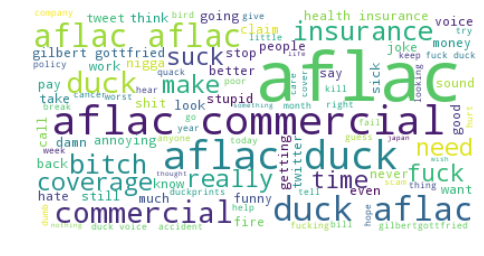

In [81]:
create_cloud(data,'Aflac')

In [110]:
remove = ['aflac','japan','duck','gilbert gottfried','gilbertgottfried','quack','duckprints','nigga','gilbert_gottfried','gilbert','gottfried']
aflac_final_tokens = final_tokens(data,'Aflac',remove)
get_topics(aflac_final_tokens,10)

Topic 1: coverage insurance better cancer employee accident tasteless thought real racist
Topic 2: commercial fuck also hurt fire_voice lmao life_insurance glad time walk
Topic 3: tweet take hope today service looking aint lose fucking nascar
Topic 4: work much stupid back years sound dude major_medical many bullshit
Topic 5: fire really know need shit hate getting life funny give
Topic 6: claim never damn tsunami ever say time going lost right
Topic 7: make money still annoying company week business dumb go try
Topic 8: bitch suck look build_empire unspeakable_nightmare twitter trouble_economics month good help
Topic 9: health_insurance joke even pay call cover policy offer guess scam
Topic 10: voice want think people making tell well hear do lame


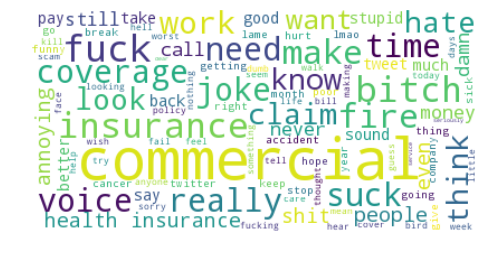

In [113]:
# WORD CLOUD AFTER REMOVING THE REDUNDANT WORDS
aflac_list = []
for l in aflac_final_tokens:
    aflac_list.extend(l)
text_aflac = " ".join(txt for txt in aflac_list) 
wc_aflac = WordCloud( max_words=100,background_color="white").generate(text_aflac)
plt.imshow(wc_aflac, interpolation='bilinear')
plt.axis("off")
plt.show()

# Cigna

['cigna', 'insurance', 'health', 'medicare', 'company', 'need', 'month', 'healthcare', 'worst', 'call', 'ever', 'plan', 'suck', 'customer', 'pay', 'care', 'dental', 'deny', 'cover', 'money', 'service', 'make', 'doctor', 'anthem', 'claim', 'coverage', 'fuck', 'people', 'aetna', 'hate', 'really', 'want', 'even', 'time', 'work', 'days', 'still', 'take', 'year', 'bill', 'deal', 'fraud', 'twitter', 'provider', 'good', 'never', 'tell', 'medical', 'commercial', 'think', 'try', 'bcbs', 'know', 'patient', 'profit', 'much', 'advantage', 'getting', 'system', 'phone', 'premium', 'back', 'thanks', 'horrible', 'cancel', 'help', 'refuse', 'wish', 'frustrate', 'medicaid', 'look', 'american', 'high', 'ridiculous', 'costs', 'bullshit', 'drug', 'deductible', 'drop', 'better', 'problem', 'receive', 'fucking', 'complaint', 'email', 'also', 'already', 'first', 'well', 'disappoint', 'waiting', 'worse', 'sick', 'fail', 'stop', 'go', 'get', 'sent', 'terrible', 'test']


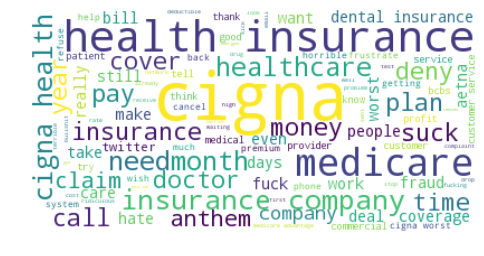

In [91]:
create_cloud(data,'Cigna')

In [107]:
remove = ['need','go','get','cigna','stop','ever','bcbs','make','tell','try','know','back','also']
cigna_final_tokens = final_tokens(data,'Cigna',remove)
get_topics(cigna_final_tokens,10)

Topic 1: health_insurance company good want refuse customer_service commercial work fail prescription
Topic 2: medicare complaint terrible le choose rate order provider health nothing
Topic 3: year medicare_medicaid program think already rather much nightmare life frustrate
Topic 4: medicare_advantage anthem claim well humana look people blame making service
Topic 5: aetna fraud health_insurance call premium customer different system phone sent
Topic 6: fuck cancel expensive hospital home profit_slump medicare_suspension ding_outlook actually disgust
Topic 7: medicare health_insurance plan pay insurance health suck coverage care cover
Topic 8: hate really never wish better med enroll money medicaid hope
Topic 9: worst first health_insurance scam horrible benefit fucking medical come years
Topic 10: insurance_company drop month thanks insurance drug work money give worse


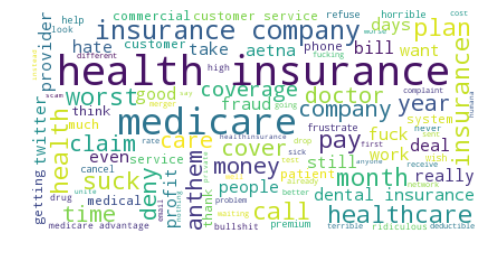

In [114]:
# WORD CLOUD AFTER REMOVING THE REDUNDANT WORDS
cigna_list = []
for l in cigna_final_tokens:
    cigna_list.extend(l)
text_cigna = " ".join(txt for txt in cigna_list) 
wc_cigna = WordCloud( max_words=100,background_color="white").generate(text_cigna)
plt.imshow(wc_cigna, interpolation='bilinear')
plt.axis("off")
plt.show()

# Allstate 

['allstate', 'insurance', 'company', 'customer', 'call', 'claim', 'show', 'service', 'policy', 'need', 'still', 'support', 'cancel', 'twitter', 'want', 'time', 'good', 'boycott', 'please', 'advertising', 'stop', 'care', 'laura', 'agent', 'ingraham', 'tell', 'people', 'help', 'take', 'make', 'try', 'know', 'hands', 'back', 'even', 'money', 'commercial', 'never', 'month', 'pay', 'years', 'advertiser', 'email', 'give', 'child', 'someone', 'say', 'life', 'phone', 'home', 'right', 'getting', 'hate', 'supporting', 'auto', 'already', 'bully', 'attack', 'drop', 'business', 'hours', 'contact', 'really', 'think', 'today', 'adjuster', 'better', 'going', 'ever', 'news', 'guy', 'worst', 'advertise', 'accident', 'well', 'hannity', 'thanks', 'issue', 'change', 'work', 'look', 'sponsor', 'keep', 'week', 'long', 'much', 'school', 'experience', 'fault', 'pull', 'state', 'suck', 'horrible', 'terrible', 'seem', 'left', 'joke', 'wrong', 'account', 'person']


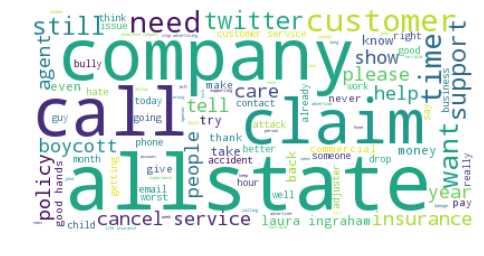

In [93]:
create_cloud(data,'Allstate')

In [108]:
remove = ['allstate','call','need','still','want','please','laura','ingraham','help','know','say','never','getting','drop','today',
         'ever','guy','right','thanks','seem','pull']
allstate_final_tokens = final_tokens(data,'Allstate',remove)
get_topics(allstate_final_tokens,10)

Topic 1: policy agent tell account contact give state sent morning thank
Topic 2: money even commercial horrible joke customer_service people sick stop phone
Topic 3: insurance good_hands insurance_company make customer business company rental geico auto
Topic 4: look work take free person accident hours think phone thing
Topic 5: try someone time insurance much month something worse friend actually
Topic 6: service tell week email cancel insult already home good suck
Topic 7: really years time take tweet send anymore find little message
Topic 8: care going company show customer back health_insurance probably dear hospital
Topic 9: claim health_insurance pay terrible adjuster customer wrong mess change worst
Topic 10: keep cover bill health_insurance provide client fraud looking least damage


# Colonial Life

['life', 'insurance', 'cancel', 'loyal', 'stupid', 'years', 'dear', 'many', 'times', 'email', 'rather', 'juggle', 'chainsaw', 'sell', 'fuck']


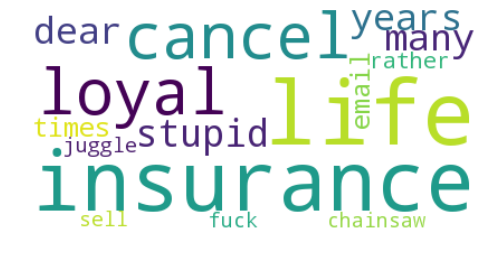

In [127]:
create_cloud(data,'Colonial Life')

In [109]:
remove = ['many','rather']
colonial_final_tokens = final_tokens(data,'Colonial Life',remove)
get_topics(colonial_final_tokens,5)

Topic 1: times life juggle email fuck dear chainsaw insurance sell years
Topic 2: life insurance stupid cancel years loyal dear juggle chainsaw sell
Topic 3: insurance life years stupid juggle loyal fuck cancel email sell
Topic 4: insurance life loyal cancel stupid years sell chainsaw dear fuck
Topic 5: life insurance years stupid cancel times juggle loyal email dear


In [111]:
data.Company.value_counts()

Aflac            26950
Cigna            10630
Allstate          4851
Colonial Life       86
Company              1
Name: Company, dtype: int64

# Topic Modeling for Met Life

In [120]:
# lOAD THE DATA
metlife = pd.read_csv('metlife_twitter_final.csv')
print(metlife.shape)
print(metlife.columns)
metlife.head()


(18843, 21)
Index(['User', 'Tweet_id', 'Timestamp', 'Message', 'Hashtags', 'Replies',
       'Retweets', 'Likes', 'Location', 'State', 'City', 'is_duplicated',
       'Sentiment_list', 'Sentiment', 'Score', 'Phrase', 'Emotion_list',
       'Emotion', 'Emotion_score', 'Company', 'Category'],
      dtype='object')


,User,Tweet_id,Timestamp,Message,Hashtags,Replies,Retweets,Likes,Location,State,...,is_duplicated,Sentiment_list,Sentiment,Score,Phrase,Emotion_list,Emotion,Emotion_score,Company,Category
0,@GiovanniFrancoA,1.05E+18,9/28/2018 16:57,MetLife Ironman 70 3 Cozumel 2018 presentado p...,NaN,NaN,NaN,2,"Oaxaca, México.",Unknown,...,False,"['Neutral', 0.9816178679466248]",Neutral,0.981618,['MetLife Ironman 70 3 Cozumel 2018 presentado...,"['joy', 0.7094311714172363]",joy,0.709431,MetLife,Brand
1,@MetAlbayrak,1.05E+18,9/28/2018 16:00,Vallahi bu d nemi nas l atlat r m bilmiyorum b...,NaN,NaN,NaN,7,"Eski?ehir, Türkiye",Unknown,...,False,"['Neutral', 0.7810289859771729]",Neutral,0.781029,['Vallahi bu d nemi nas l atlat r m bilmiyorum...,"['sadness', 0.29014238715171814]",sadness,0.290142,MetLife,Brand
2,@happilylarry_x,1.05E+18,9/28/2018 15:58,MetLife 2014 pic twitter com eFloA1yS4W,NaN,1,NaN,2,?LARRY FBI™??,Unknown,...,False,"['Neutral', 0.9801350235939026]",Neutral,0.980135,['MetLife 2014 pic twitter com eFloA1yS4'],"['joy', 0.2850568890571594]",joy,0.285057,MetLife,Brand
3,@Tregroovy,1.05E+18,9/28/2018 15:55,What s funny is pulled up to metlife bumping t...,NaN,NaN,NaN,NaN,BULLY UP NYG,Unknown,...,False,"['Negative', 0.7833356261253357]",Negative,0.783336,['metlife'],"['anger', 0.46428608894348145]",anger,0.464286,MetLife,Brand
4,@HoyenCozumel,1.05E+18,9/28/2018 15:37,IsladelDeporte MetLife IronMan 70 3 Lo mejor d...,#IsladelDeporte #IronMan #IslaCozumel #BastaDe...,NaN,NaN,NaN,NaN,Unknown,...,False,"['Neutral', 0.9842604994773865]",Neutral,0.984260,['IsladelDeporte MetLife IronMan 70 3 Lo mejor...,"['surprise', 0.46396785974502563]",surprise,0.463968,MetLife,Brand


In [133]:
df = metlife[metlife['Sentiment'] == 'Negative']
negative_tweets = []
df.reset_index(inplace=True)
for i in range(df.shape[0]):
    negative_tweets.append(df['Message'][i])
    
clean_tweets = []
for c in negative_tweets:
    cleaned = clean(c)
    clean_tweets.append(cleaned)
        
clean_tokens = []
for c in clean_tweets:
    tokens = word_tokenize(c)
    clean_tokens.append(tokens)

['metlife', 'show', 'night', 'insurance', 'fuck', 'company', 'going', 'still', 'time', 'call', 'even', 'need', 'twitter', 'game', 'want', 'customer', 'fucking', 'look', 'policy', 'make', 'people', 'really', 'know', 'literally', 'try', 'go', 'taylor', 'never', 'service', 'think', 'give', 'worst', 'take', 'getting', 'play', 'shit', 'cancel', 'week', 'phone', 'please', 'bitch', 'right', 'last', 'back', 'help', 'years', 'rain', 'giant', 'jet', 'claim', 'jersey', 'come', 'someone', 'also', 'say', 'sorry', 'work', 'month', 'first', 'miss', 'better', 'life', 'support', 'hate', 'today', 'good', 'business', 'year', 'tweet', 'otra', 'pay', 'nothing', 'home', 'team', 'stop', 'everyone', 'much', 'long', 'suck', 'already', 'website', 'piss', 'next', 'start', 'email', 'pitch', 'tell', 'ever', 'cant', 'money', 'days', 'number', 'guy', 'guest', 'hard', 'lose', 'keep', 'care', 'enough', 'hope']


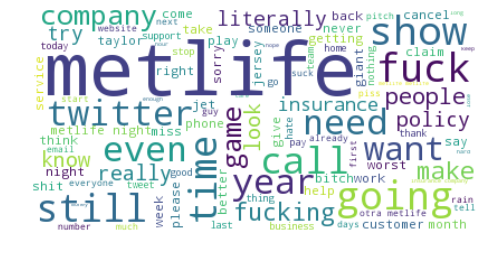

In [134]:
text = " ".join(txt for txt in clean_tweets)
words = []
tokens = nltk.tokenize.word_tokenize(text)
fd = nltk.FreqDist(tokens)
for word, frequency in fd.most_common(100):
    words.append(word)
print(words)
wc = WordCloud( max_words=100,background_color="white").generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [137]:
remove = ['metlife','show','want','still','even','need','really','know','try','go','think','give','take','please','phone','last',
         'back','also','say','otra','stop','much','long','next','start','tell','ever','cant']
tokens_new = []
for i in clean_tokens:
    tokens_new.append([token for token in i if token not in remove])
get_topics(tokens_new,10)

Topic 1: cancel email tweet fraud address never cancel_policy team guess left
Topic 2: customer kind anyone enough reply total seriously chat company live
Topic 3: right today claim people service days work provide insurance piss
Topic 4: help answer issue literally years fucking life taylor hold bill
Topic 5: twitter company talk make bitch first representative manager nothing end
Topic 6: play name home instead bring hour friend rep care change
Topic 7: game miss week website sorry thing anything jet second adjuster
Topic 8: night site worst stadium better getting jersey sure experience cause
Topic 9: policy call fuck someone customer_service shit fail terrible damn hope
Topic 10: going support time business month death everyone refund full stay


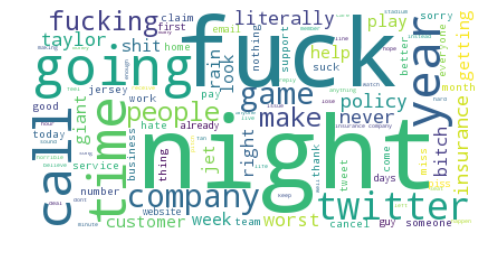

In [138]:
metlife_list = []
for l in tokens_new:
    metlife_list.extend(l)
text_metlife = " ".join(txt for txt in metlife_list) 
wc_metlife = WordCloud( max_words=100,background_color="white").generate(text_metlife)
plt.imshow(wc_metlife, interpolation='bilinear')
plt.axis("off")
plt.show()